<a href="https://colab.research.google.com/github/Astromax/Retina_Disease_Classification/blob/main/EyeDiseaseDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The purpose of this is to determine whether or not a retina is healthy, and, if not, which of six different diseases it has. The data for this comes from a Kaggle competition, https://www.kaggle.com/c/vietai-advance-course-retinal-disease-detection/overview.
 There are 3,435 training images, with the following label breakdown: opacity - 0, diabetic retinopathy - 1, glaucoma - 2, macular edema - 3, macular degeneration - 4, retinal vascular occlusion - 5, and normal - 6.
An important note: unlike an ordinary classification problem, in this case a retina may be afflicted with more than one ailment.  Because of this, the activation function for the final layer is sigmoid, instead of the usual softmax, effectively providing a probability for each label independent of the others.

The data has been uploaded to my Google Drive for easy access & processing, if anyone reading this wants to replicate it just change the target directories.

In [1]:
#First let's mount the Drive so we can access the data...
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir('/content/drive/MyDrive/EyeDiseaseDetection/')

In [3]:
from resnet_module_helpers_tf import *
from eye_DD_metrics_helpers import *
from training_plot_helpers import *

# Display
from IPython.display import Image, display
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image, ImageDraw
from plotly.subplots import make_subplots
import seaborn as sns
from sklearn.metrics import multilabel_confusion_matrix as MLCM
from sklearn.model_selection import train_test_split
import tensorflow as tf

from keras.activations import relu
from keras.optimizers import Adam
from keras.optimizers.schedules import ExponentialDecay
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, Flatten, MaxPool2D, Dense, Dropout, Input, BatchNormalization, Activation
from keras.layers.experimental.preprocessing import RandomCrop, RandomFlip, RandomRotation
from tqdm import tqdm

physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [4]:
#Establish location of data
data_dir = './Data/Data/train'
image_dir = data_dir+'/train'

In [5]:
filenames = os.listdir(image_dir)
print('Number of files: ', len(filenames))

Number of files:  3435


Before doing the heavy-duty analysis, let's first make sure there are no anomalies.  A retina can have multiple diseases simultaneously, which means this is not a simple image classification problem.  However, there is also a seventh label, 'Normal', corresponding to a healthy retina.  If a retina has a disease it is, by definition, unhealthy, therefore any images with a one in the 'Normal' column *and any other* is an anomaly, which should be excluded from the analysis.  Similarly, an image with all zeros, corresponding to either a mislabel or a retina with a disease not in this set, is not useful for this analysis.

In [6]:
#Let's check for anomalies and see how many of each disease type there are....
labels_df = pd.read_csv(data_dir+'/train.csv')
print('Number of all-zero anomalies: ', labels_df[(labels_df['opacity'] == 0) & (labels_df['diabetic retinopathy']==0)
& (labels_df['glaucoma'] == 0) & (labels_df['macular edema'] == 0) & (labels_df['macular degeneration'] == 0) 
& (labels_df['retinal vascular occlusion'] == 0) & (labels_df['normal'] == 0)].count())

print('Number of inconsistencies: ', labels_df[((labels_df['opacity'] == 1) | (labels_df['diabetic retinopathy']==1)
| (labels_df['glaucoma'] == 1) | (labels_df['macular edema'] == 1) | (labels_df['macular degeneration'] == 1) 
| (labels_df['retinal vascular occlusion'] == 1)) & (labels_df['normal'] == 1)].count())

print('Opacity count: ')
print(labels_df['opacity'].value_counts())
print('Diabetic Retinopathy count: ')
print(labels_df['diabetic retinopathy'].value_counts())
print('Glaucoma count: ')
print(labels_df['glaucoma'].value_counts())
print('Macular Edema count:')
print(labels_df['macular edema'].value_counts())
print('Macular Degeneration count:')
print(labels_df['macular degeneration'].value_counts())
print('Retinal Vascular Occlusion count: ')
print(labels_df['retinal vascular occlusion'].value_counts())
print('Normal count: ')
print(labels_df['normal'].value_counts())

Number of all-zero anomalies:  filename                      0
opacity                       0
diabetic retinopathy          0
glaucoma                      0
macular edema                 0
macular degeneration          0
retinal vascular occlusion    0
normal                        0
dtype: int64
Number of inconsistencies:  filename                      0
opacity                       0
diabetic retinopathy          0
glaucoma                      0
macular edema                 0
macular degeneration          0
retinal vascular occlusion    0
normal                        0
dtype: int64
Opacity count: 
0    1902
1    1533
Name: opacity, dtype: int64
Diabetic Retinopathy count: 
0    2680
1     755
Name: diabetic retinopathy, dtype: int64
Glaucoma count: 
0    2838
1     597
Name: glaucoma, dtype: int64
Macular Edema count:
0    2919
1     516
Name: macular edema, dtype: int64
Macular Degeneration count:
0    2861
1     574
Name: macular degeneration, dtype: int64
Retinal Vascular Oc

**TO DO**: Some EDA to see what kinds of correlations there are between the different diseases.

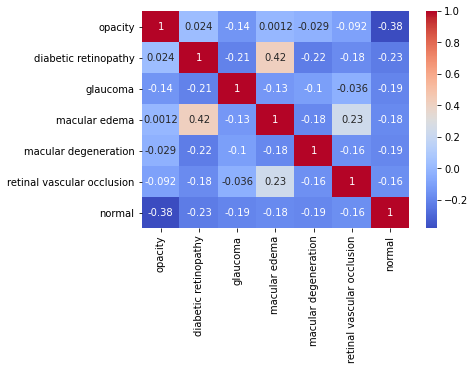

In [7]:
#Let's get the correlations between all pairs of columns and plot them as a heatmap
sns.heatmap(labels_df.corr(), annot=True, fmt='0.2g', cmap='coolwarm')

We see there is some correlation between diabetic retinopathy and macular edema, and a more mild correlation between macular edema and retinal vascular occlusion.  Normality is anti-correlated with all other labels, which is to be expected, although the magnitude is not as great as I would have expected.  Diabetic retinopathy is anti-correlated with glaucoma and macular degeneration.  More domain knowledge is necessary to interpret these (anti)correlations, but they are interesting nonetheless.

To streamline the process of entering in the labels for training, we first create a new column consolidating the entries in the seven main columns into a column of 7-tuples.  This is the "y" that the model is learning from and trying to predict.

In [8]:
#Convert the individual label values to int type, add in a multi-hot vector label
MH = list(zip(labels_df['opacity'], labels_df['diabetic retinopathy'], labels_df['glaucoma'], labels_df['macular edema'],
                                  labels_df['macular degeneration'], labels_df['retinal vascular occlusion'], labels_df['normal']))
labels_df['Multi_Hot'] = MH

In [9]:
y = labels_df['Multi_Hot']
y = np.array([y.iloc[i] for i in range(len(y))])
print('Length of y: ', len(y))

Length of y:  3435


Here we load in the full set of images.  tqdm produces the progress bar and is not strictly necessary, but with this many images it can be nice to know how much longer to expect.  Google Colab has quite a bit of variability, in some experiments it loaded the full dataset in under 10 minutes, while other times it took more than half an hour.

In [10]:
train_images = []
for i in tqdm(range(labels_df.shape[0])):
    img = image.load_img(image_dir+'/'+ labels_df['filename'][i], target_size=(224,224,3), grayscale=False)
    img = image.img_to_array(img)
    img = img/255
    train_images.append(img)

X = np.array(train_images)


100%|██████████| 3435/3435 [12:30<00:00,  4.58it/s]


In [11]:
#Perform the train_test split.  Fix random_state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=37, test_size=0.3)
print('Length of X_train: ', len(X_train))
print('Length of X_test: ', len(X_test))

Length of X_train:  2404
Length of X_test:  1031


In [12]:
#Specifying the batch_size hyperparameter.
#I have heard it claimed that batch_size larger than 32 does not improve performance (see https://arxiv.org/pdf/1804.07612.pdf),
#so I'm going to hold batch_size to 16 here just to be safe. 
train_batch_size = 16

We will want to augment the training set. For these images, vertical & horizontal flips as well as random rotations are valid transformations. Manipulating the colors is probably not a valid transformation as that might plausibly change the actual meaning, although I could be mistaken in this.
The Keras ImageDataGenerator also has shear & shift parameters, which should be valid augmentations for this sort of data as long as the parameters aren't too large.

In [13]:
#Hyperparameters: rotation_angle, width/height_shift_range, shear

# Create a Data Generator
data_gen_args = dict( 
    rotation_range=45,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.2,
    channel_shift_range=0.05,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='constant',
    data_format="channels_last",
)
image_datagen = ImageDataGenerator(**data_gen_args)

image_datagen.fit(X_train)

In [14]:
train_generator = image_datagen.flow(X_train, y_train, batch_size=train_batch_size)
val_generator = image_datagen.flow(X_test, y_test, batch_size=train_batch_size)

ResNets are the name of the game for this project, so let's start by defining an n-convolutional-layer resnet component. The original ResNet set n=2, but I've decided to experiment with adding more layers to each component.
Acknowledgement: this code is based on the example code found here https://d2l.ai/chapter_convolutional-modern/resnet.html

This is where the resnet module helpers come in: GeneralResnetBlock is defined in that function, it determines the complexity of the individual resnet blocks.  For the first model, we are using four 3-layer core modules, with a GoogLeNet head and tail bracketing the resnet blocks.

In [15]:
def model_one():
    return Sequential([
           Conv2D(64, kernel_size=7, strides=2, padding='same'),
           BatchNormalization(),
           tf.keras.layers.Activation('relu'),
           tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same'),      
           GeneralResnetBlock(3, 64, 2, first_block=True),
           GeneralResnetBlock(3, 128, 2),
           GeneralResnetBlock(3, 256, 2),
           GeneralResnetBlock(3, 512, 2),
           tf.keras.layers.GlobalAvgPool2D(),
           tf.keras.layers.Dense(7, activation='sigmoid')
    ])

In [16]:
#Let's see how this affects the shape of an input
R = tf.random.uniform(shape=(16, 224, 224, 3))
for layer in model_one().layers:
    R = layer(R)
    print(layer.__class__.__name__, 'output shape:\t', R.shape)

Conv2D output shape:	 (16, 112, 112, 64)
BatchNormalization output shape:	 (16, 112, 112, 64)
ModuleWrapper output shape:	 (16, 112, 112, 64)
ModuleWrapper output shape:	 (16, 56, 56, 64)
ModuleWrapper output shape:	 (16, 56, 56, 64)
ModuleWrapper output shape:	 (16, 28, 28, 128)
ModuleWrapper output shape:	 (16, 14, 14, 256)
ModuleWrapper output shape:	 (16, 7, 7, 512)
ModuleWrapper output shape:	 (16, 512)
ModuleWrapper output shape:	 (16, 7)


We need to specify which loss function to use and which optimizer to use.  This is a multi-label classification problem, which means softmax is NOT the appropriate choice, instead each individual output node has a logistic loss associated with it, so the output of a particular node corresponds to the probability of that trait (ex. glaucoma) being present in the image.  There is one catch: one of the categories is "Normal", which by definition is mutually exclusive with the combined set of the other six categories. Ideally there would be a way to enforce unitarity, that is, Prob(Normal) + Prob(Not Normal) = 1, but it is not clear at this point how to do so.

It is generally known that learning rate decay improves performance, the basic logic being that the model is unlikely to start near the global optimum so large steps are taken initially, then as it approaches the optimum step size reduces so as to not overshoot.  Many different schemes for learning rate decay have been proposed, for this project we are using the simple Exponential Decay, which Keras has as a built-in.  There are three hyperparameters associated with this scheduler: initial_learning_rate, decay_steps, and decay_rate.  The initial_learning_rate is self-explanatory and is also the one which is most variable in different experiments, the value of 3e-4 being on the smaller side relative to what I have seen others use.  Given more time I would test out other settings, probably going larger first (ex. ilr = 0.01).  The decay_steps and decay_rate parameters are set to what I believe are their commonly-used values, I would only manipulate these after other avenues of optimization have been exhausted.

In [17]:
#Scheduler for the learning rate decay.  
#Hyperparameters: initial_learning_rate, decay_steps, decay_rate
irl = 3e-4
dsteps = 10000
drate = 0.9
lr_scheduler = ExponentialDecay(
    initial_learning_rate=irl,
    decay_steps=dsteps,
    decay_rate=drate)

In [18]:
#Set the number of training epochs
EPOCHS = 50

In [19]:
Model_One = model_one()
Model_One.compile(optimizer=Adam(learning_rate=lr_scheduler, epsilon=1e-8),
                   loss='binary_crossentropy',
                   metrics=[tf.keras.metrics.Recall(), 'binary_accuracy'])


In [20]:
M1_history = Model_One.fit(train_generator,
                           validation_data = (X_test, y_test),
                           epochs=EPOCHS)

Epoch 1/50
151/151 [==============================] - 51s 205ms/step - loss: 0.5331 - recall: 0.2946 - binary_accuracy: 0.7758 - val_loss: 0.5505 - val_recall: 0.2557 - val_binary_accuracy: 0.7833
Epoch 2/50
151/151 [==============================] - 28s 187ms/step - loss: 0.4324 - recall: 0.2662 - binary_accuracy: 0.8187 - val_loss: 0.6067 - val_recall: 0.2738 - val_binary_accuracy: 0.7832
Epoch 3/50
151/151 [==============================] - 28s 187ms/step - loss: 0.4233 - recall: 0.2786 - binary_accuracy: 0.8234 - val_loss: 0.4394 - val_recall: 0.2846 - val_binary_accuracy: 0.8250
Epoch 4/50
151/151 [==============================] - 28s 186ms/step - loss: 0.4135 - recall: 0.2876 - binary_accuracy: 0.8269 - val_loss: 0.4280 - val_recall: 0.2931 - val_binary_accuracy: 0.8275
Epoch 5/50
151/151 [==============================] - 28s 188ms/step - loss: 0.3986 - recall: 0.2974 - binary_accuracy: 0.8333 - val_loss: 0.4560 - val_recall: 0.3005 - val_binary_accuracy: 0.8147
Epoch 6/50
151/

#Metric Time!!
For this project, there are seven labels which may be applied to any given image, with the only constraint being that the last one (index 6 indicating 'Normal') cannot be set to one if any others are also set to one. The standard metrics are Accuracy, Precision, Recall, and F1 Score, each of which has it's strengths and weaknesses.  
TP: True Positive 
TN: True Negative
FP: False Positive
FN: False Negative
#Accuracy = (TP + TN)/(TP + TN + FP + FN)
#Precision = TP/(TP + FP)
#Recall = TP/(TP + FN)
#F1 = (2PR)/(P + R)
Generally, for a medical test looking for a disease-state (indices 0 - 5 inclusive in this case), False Negatives are considered to be much worse than False Positives, because a person is being given a clean bill of health when in reality they have the disease condition, as such they are unlikely to get appropriate treatment as quickly.  Therefore *Recall* is generally more important than Accuracy or Precision for tests looking for a disease-state.  
In contrast, index 6 corresponds to a test for a healthy-state, so the roles are reversed: a False Positive means "clean bill of health when actually ill" and False Negative means "told one is ill when one is actually fine", therefore Precision is the more important metric.
Choosing an appropriate metric is complicated by the fact that there are six distinct disease states and only one healthy state, so a simple addition of the disease-state Recalls and the healthy-state Precision potentially ignores the case where a person has a disease but the algorithm isn't sure which.  This can be somewhat ameliorated by weighting Precision for healthy-state higher than the Recalls for the disease states, which is the approach taken here.  To really do this properly, one should consult with opthamologists to devise a single overall metric to judge by.

In [21]:
#Create the multi-label confusion matrix
M_predictions = Model_One.predict(X_test)
M_predictions_hard = np.round_(M_predictions)

M_MLCM = MLCM(y_test, M_predictions_hard)

We will now compute all of the usual metrics for each disease-state and the healthy-state, even though at the moment only a few will be used.

In [22]:
#Recall the index ordering: 0 - Opacity, 1 - Diabetic Retinopathy, 2 - Glaucoma, 3 - Macular Edema,
# 4 - Macular Degeneration,  5 - Retinal Vascular Occlusion, 6 - Normal

index_map = {0: 'Opacity', 1: 'Diabetic Retinopathy', 2: 'Glaucoma', 3: 'Macular Edema', 4: 'Macular Degeneration', 
             5: 'Retinal Vascular Occlusion', 6: 'Normal'}

overall_score = 0 #A perfect score, indicating perfect Recall on all disease states and perfect Precision for the healthy state, would be 12

for i, cm in enumerate(M_MLCM):
    if i < 6:
        overall_score += recall_from_CM(cm)
    else:
        overall_score += 6 * precision_from_CM(cm)
    print('|---------------- %s -------------------|' % index_map[i])
    print('Accuracy: ', accuracy_from_CM(cm))
    print('Precision: ', precision_from_CM(cm))
    print('Recall: ', recall_from_CM(cm))
    print('F1 Score: ', F1_from_CM(cm))

print('+++++++++++++++++++++++++++++++++++++')
print('Overall score: ', overall_score)

|---------------- Opacity -------------------|
Accuracy:  0.7963142580019399
Precision:  0.7186963979416809
Recall:  0.9010752688172043
F1 Score:  0.799618320610687
|---------------- Diabetic Retinopathy -------------------|
Accuracy:  0.8157129000969933
Precision:  0.6280487804878049
Recall:  0.44396551724137934
F1 Score:  0.5202020202020202
|---------------- Glaucoma -------------------|
Accuracy:  0.8729388942774006
Precision:  0.7727272727272727
Recall:  0.37988826815642457
F1 Score:  0.5093632958801498
|---------------- Macular Edema -------------------|
Accuracy:  0.8603297769156159
Precision:  0.4444444444444444
Recall:  0.29850746268656714
F1 Score:  0.3571428571428571
|---------------- Macular Degeneration -------------------|
Accuracy:  0.8768186226964112
Precision:  0.7547169811320755
Recall:  0.4419889502762431
F1 Score:  0.5574912891986062
|---------------- Retinal Vascular Occlusion -------------------|
Accuracy:  0.9088263821532493
Precision:  0.7291666666666666
Recall: 